In [1]:
# Import 1
# in your notebook cell
import sys
# path relative to your notebook
sys.path.append("/Users/joel/Desktop/daimil10/capstone_1/DC-Metro-Crime-Data-2007---2017/src")
# import as usual
import functions

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# Import 2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style

In [3]:
# Read file in and drop first two rows
# First two rows seem to make like no sense with the rest of this data set
df = functions.read_file('/Users/joel/Desktop/daimil10/capstone_1/DC-Metro-Crime-Data-2007---2017/data/dc_crime_add_vars.csv')
df = df.drop(['Unnamed: 0', 'X'], axis=1)
df.head()

,REPORT_DAT,SHIFT,OFFENSE,METHOD,BLOCK,DISTRICT,PSA,WARD,ANC,NEIGHBORHOOD_CLUSTER,...,year,month,day,hour,minute,second,EW,NS,quad,crimetype
0,8/31/2008 8:47:00 PM,EVENING,THEFT/OTHER,OTHERS,3500 - 3599 BLOCK OF R STREET NW,2.0,206.0,2,2E,Cluster 4,...,2008,8,31,20,47,0,West,North,Northwest,Non-Violent
1,9/1/2008 12:45:00 AM,MIDNIGHT,MOTOR VEHICLE THEFT,OTHERS,2000 - 2015 BLOCK OF O STREET NW,2.0,208.0,2,2B,Cluster 6,...,2008,9,1,0,45,0,West,North,Northwest,Non-Violent
2,9/1/2008 3:00:00 AM,MIDNIGHT,THEFT/OTHER,OTHERS,700 - 799 BLOCK OF 11TH STREET NW,1.0,101.0,2,2C,Cluster 8,...,2008,9,1,3,0,0,East,North,Northeast,Non-Violent
3,9/9/2008 7:46:00 AM,DAY,THEFT/OTHER,OTHERS,1700 - 1799 BLOCK OF P STREET NW,2.0,208.0,2,2B,Cluster 6,...,2008,9,9,7,46,0,West,North,Northwest,Non-Violent
4,8/24/2008 8:00:00 PM,EVENING,MOTOR VEHICLE THEFT,OTHERS,500 - 599 BLOCK OF INDIANA AVENUE NW,1.0,102.0,2,2C,Cluster 8,...,2008,8,24,20,0,0,East,North,Northeast,Non-Violent


In [4]:
# Describing the Dataset 1
df.describe()

,DISTRICT,PSA,WARD,CENSUS_TRACT,CCN,XBLOCK,YBLOCK,year,month,day,hour,minute,second
count,342667.000000,342616.000000,342867.000000,341776.000000,3.428670e+05,342867.000000,342867.000000,342867.000000,342867.000000,342867.000000,342867.000000,342867.000000,342867.000000
mean,3.727415,378.080069,4.449501,6218.780511,1.265285e+07,-77.008139,38.905970,2012.543651,6.655686,15.979505,13.228853,26.294750,6.789986
std,1.977502,197.334627,2.378859,3137.022064,2.845777e+06,0.036324,0.031595,2.810362,3.327466,8.760185,6.233693,18.106904,14.926954
min,1.000000,101.000000,1.000000,100.000000,1.000600e+05,-77.113642,38.813470,2008.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.000000,206.000000,2.000000,3500.000000,1.012491e+07,-77.032380,38.890940,2010.000000,4.000000,8.000000,9.000000,10.000000,0.000000
50%,4.000000,401.000000,5.000000,7000.000000,1.303074e+07,-77.013122,38.906430,2013.000000,7.000000,16.000000,14.000000,28.000000,0.000000
75%,5.000000,507.000000,6.000000,8904.000000,1.510258e+07,-76.985523,38.925286,2015.000000,9.000000,23.000000,18.000000,42.000000,0.000000
max,7.000000,708.000000,8.000000,11100.000000,9.943899e+07,-76.910010,38.994901,2017.000000,12.000000,31.000000,23.000000,59.000000,59.000000


In [5]:
# Describing the Dataset 2
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342867 entries, 0 to 342866
Data columns (total 30 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   REPORT_DAT            342867 non-null  object 
 1   SHIFT                 342867 non-null  object 
 2   OFFENSE               342867 non-null  object 
 3   METHOD                342867 non-null  object 
 4   BLOCK                 342867 non-null  object 
 5   DISTRICT              342667 non-null  float64
 6   PSA                   342616 non-null  float64
 7   WARD                  342867 non-null  int64  
 8   ANC                   342867 non-null  object 
 9   NEIGHBORHOOD_CLUSTER  338162 non-null  object 
 10  BLOCK_GROUP           341776 non-null  object 
 11  CENSUS_TRACT          341776 non-null  float64
 12  VOTING_PRECINCT       342783 non-null  object 
 13  CCN                   342867 non-null  int64  
 14  START_DATE            342854 non-null  object 
 15  

In [6]:
# Describing the Dataset 3
df.index

RangeIndex(start=0, stop=342867, step=1)

In [7]:
# Describing the Dataset 4
df.columns

Index(['REPORT_DAT', 'SHIFT', 'OFFENSE', 'METHOD', 'BLOCK', 'DISTRICT', 'PSA',
       'WARD', 'ANC', 'NEIGHBORHOOD_CLUSTER', 'BLOCK_GROUP', 'CENSUS_TRACT',
       'VOTING_PRECINCT', 'CCN', 'START_DATE', 'END_DATE', 'XBLOCK', 'YBLOCK',
       'optional', 'date', 'year', 'month', 'day', 'hour', 'minute', 'second',
       'EW', 'NS', 'quad', 'crimetype'],
      dtype='object')

In [ ]:
# Describing the Dataset 5
missing_v = df.isnull().sum()
missing_v

# new dataframe of al missing values
data = {
    'DISTRICT': [200],
    'PSA': [251],
    'NEIGHBORHOOD_CLUSTER': [4705],
    'BLOCK_GROUP': [1091],
    'CENSUS_TRACT': [1091],
    'VOTING_PRECINCT': [84],
    'START_DATE': [13],
    'END_DATE': [11651],
    'XBLOCK': [0],
    'YBLOCK': [0],
    'date': [0],
    'year': [0],
    'month': [0],
    'day': [0],
    'hour': [0],
    'minute': [0],
    'second': [0]
}

# show the missing data
df_bar = pd.DataFrame(data)
plt.figure(figsize=(12, 6))
df_bar.plot(kind='bar', edgecolor='black')

plt.xlabel('Col Name')
plt.ylabel('Missing Values')
plt.title('Missing Values in Dataset')
plt.show()

In [8]:
# Describing the Dataset 6
# Went from 342867 to 325340 = 17527 removed which is roughly 5% of the dataset 
df = functions.drop_rows_with_missing_data(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325340 entries, 0 to 342866
Data columns (total 30 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   REPORT_DAT            325340 non-null  object 
 1   SHIFT                 325340 non-null  object 
 2   OFFENSE               325340 non-null  object 
 3   METHOD                325340 non-null  object 
 4   BLOCK                 325340 non-null  object 
 5   DISTRICT              325340 non-null  float64
 6   PSA                   325340 non-null  float64
 7   WARD                  325340 non-null  int64  
 8   ANC                   325340 non-null  object 
 9   NEIGHBORHOOD_CLUSTER  325340 non-null  object 
 10  BLOCK_GROUP           325340 non-null  object 
 11  CENSUS_TRACT          325340 non-null  float64
 12  VOTING_PRECINCT       325340 non-null  object 
 13  CCN                   325340 non-null  int64  
 14  START_DATE            325340 non-null  object 
 15  

In [9]:
# Describing the Dataset 7
functions.describe_dataframe(df)

,DISTRICT,PSA,WARD,CENSUS_TRACT,CCN,XBLOCK,YBLOCK,year,month,day,hour,minute,second
count,"325,340","325,340","325,340","325,340","325,340","325,340","325,340","325,340","325,340","325,340","325,340","325,340","325,340"
mean,4,375,4,"6,184","12,693,307",-77,39,"2,013",7,16,13,26,7
std,2,196,2,"3,138","2,843,354",0,0,3,3,9,6,18,15
min,1,101,1,100,"100,060",-77,39,"2,008",1,1,0,0,0
25%,2,206,2,"3,500","10,136,018",-77,39,"2,010",4,8,9,10,0
50%,3,308,5,"7,000","13,051,711",-77,39,"2,013",7,16,14,28,0
75%,5,507,6,"8,904","15,105,125",-77,39,"2,015",9,23,18,42,0
max,7,708,8,"11,100","99,438,989",-77,39,"2,017",12,31,23,59,59


In [10]:
# Describing the Dataset 8
functions.get_column_features(df)

{'REPORT_DAT': dtype('O'),
 'SHIFT': dtype('O'),
 'OFFENSE': dtype('O'),
 'METHOD': dtype('O'),
 'BLOCK': dtype('O'),
 'DISTRICT': dtype('float64'),
 'PSA': dtype('float64'),
 'WARD': dtype('int64'),
 'ANC': dtype('O'),
 'NEIGHBORHOOD_CLUSTER': dtype('O'),
 'BLOCK_GROUP': dtype('O'),
 'CENSUS_TRACT': dtype('float64'),
 'VOTING_PRECINCT': dtype('O'),
 'CCN': dtype('int64'),
 'START_DATE': dtype('O'),
 'END_DATE': dtype('O'),
 'XBLOCK': dtype('float64'),
 'YBLOCK': dtype('float64'),
 'optional': dtype('bool'),
 'date': dtype('O'),
 'year': dtype('int64'),
 'month': dtype('int64'),
 'day': dtype('int64'),
 'hour': dtype('int64'),
 'minute': dtype('int64'),
 'second': dtype('int64'),
 'EW': dtype('O'),
 'NS': dtype('O'),
 'quad': dtype('O'),
 'crimetype': dtype('O')}

In [ ]:
# Can use this is need to or can slice the other df accordingly
 
# Slice df to only include the offense of homicide

# Convert datetimes

# Make new start and end hour column
df_2 = df[df['OFFENSE']=='HOMICIDE']
df_2['START_DATE'] = pd.to_datetime(df_2['START_DATE'])
df_2['END_DATE'] = pd.to_datetime(df_2['END_DATE'])
df_2['start_hour'] = df_2['START_DATE'].dt.hour
df_2['end_hour'] = df_2['START_DATE'].dt.hour
df_2 = df_2.drop('hour', axis=1)
df_2.head()

In [ ]:
# Can use this is need to or can slice the other df accordingly 

# 1100 rows now
hom_df = df_2

# Slicing df one last time to get only my desired columns
hom_df = hom_df[['REPORT_DAT',
                'SHIFT',
                'OFFENSE',
                'METHOD',
                'BLOCK',
                'DISTRICT',
                'PSA',
                'WARD',
                'ANC',
                'NEIGHBORHOOD_CLUSTER',
                'BLOCK_GROUP',
                'VOTING_PRECINCT',
                'START_DATE',
                'END_DATE',
                'XBLOCK',
                'YBLOCK',
                'date',
                'year',
                'start_hour',
                'end_hour',
                'crimetype']]

#Show that it worked
hom_df.columns

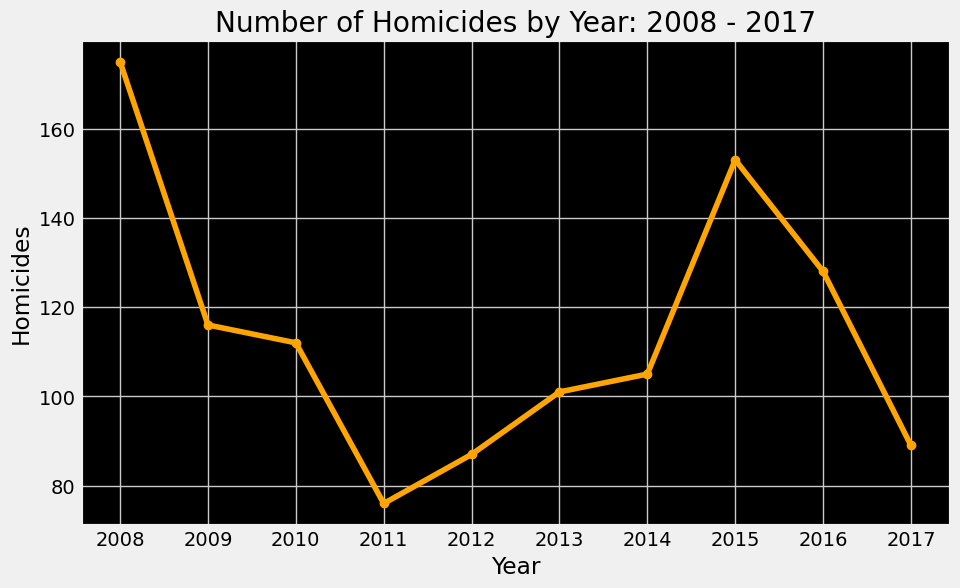

In [58]:
# Have homicides increased over this decade?
# Line Chart

from matplotlib import style

homicides_df = df[df['OFFENSE'] == 'HOMICIDE']
# Group the data by year and count the number of homicides per year
homicides_by_year = homicides_df.groupby('year').size()

plotter = functions.Plot()
plotter.line_chart(homicides_by_year, 'Year', 'Homicides', 'Number of Homicides by Year: 2008 - 2017')

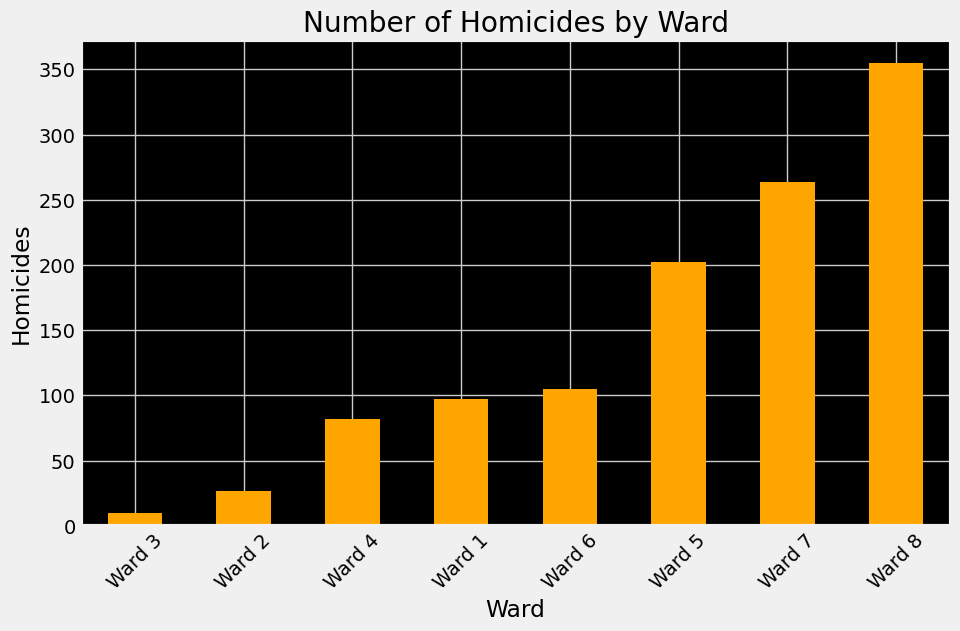

In [66]:
# Which wards / neighborhoods had the highest number of homicides?
# Bar Chart

# Filter the DataFrame for homicides
homicides_df = df[df['OFFENSE'] == 'HOMICIDE']

# Get homicides by district value counts and sort values
homicides_by_location = homicides_df['WARD'].value_counts().sort_values()

plotter.bar_chart(homicides_by_location, 'Ward', 'Homicides', 'Number of Homicides by Ward')

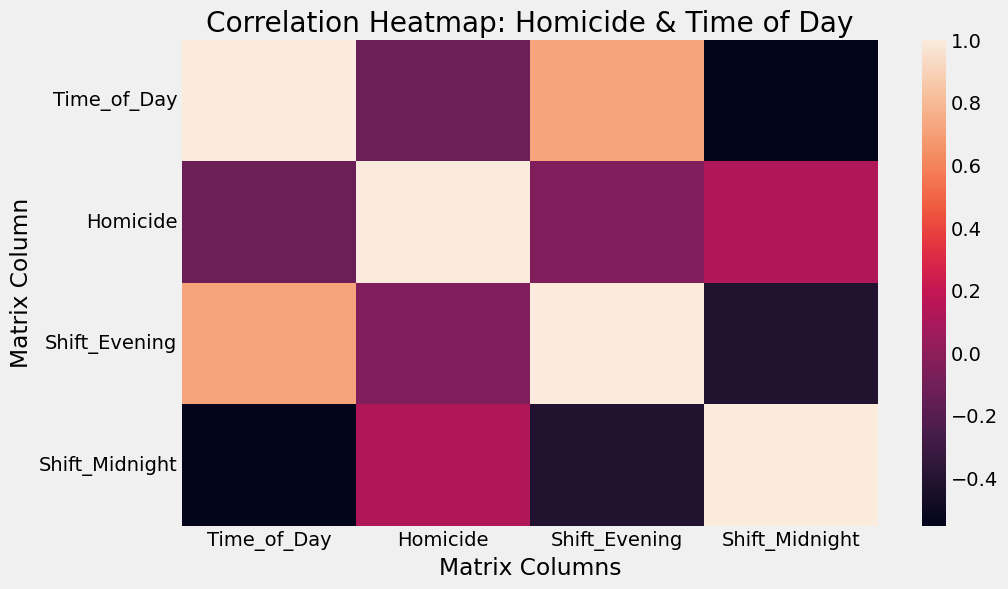

In [68]:
# Is there any correlation between the time of the day and the occurrence of homicides?
# Heat Map

# Extract the hour from the 'REPORT_DAT' column
df['Time_of_Day'] = pd.to_datetime(df['REPORT_DAT']).dt.hour

# Create a binary(dummy) column for the cat columns
df['Homicide'] = df['OFFENSE'].apply(lambda x: 1 if 'HOMICIDE' in x else 0)
df['Shift_Evening'] = df['SHIFT'].apply(lambda x: 1 if 'EVENING' in x else 0)
df['Shift_Midnight'] = df['SHIFT'].apply(lambda x: 1 if 'MIDNIGHT' in x else 0)

# Select the columns of interest
correlation_df= df[['Time_of_Day', 'Homicide', 'Shift_Evening', 'Shift_Midnight']]
corr_matrix = correlation_df.corr()

plotter.heatmap(corr_matrix, 'Matrix Columns', 'Matrix Column', 'Correlation Heatmap: Homicide & Time of Day')

<Figure size 1600x1200 with 0 Axes>

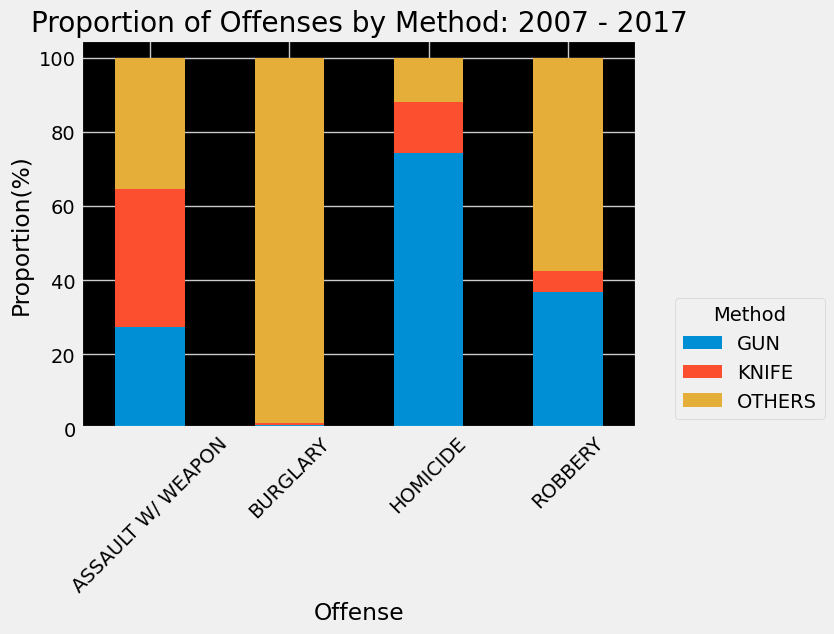

In [72]:
# Are homicides more likely to occur with a gun or a knife? 
# Stacked Plot

#replace method
df['OFFENSE'] = df['OFFENSE'].replace('ASSAULT W/DANGEROUS WEAPON', 'ASSAULT W/ WEAPON')

# Select list of violent offenses
offenses = ['HOMICIDE', 'ROBBERY', 'ASSAULT W/ WEAPON', 'BURGLARY']

# Filter the DataFrame using isin cause i keep getting value error? 
filtered_df = df[df['OFFENSE'].isin(offenses)]

# Group the data by offense and method, and count
# .size()is used after grouping the data to count the number of occurrences 
# for each group. It returns a Series or DataFrame with the counts.
# .unstack() is applied to a hierarchical index (such as the result of a groupby operation) 
# and reshapes the data by "unstacking" one level of the index to create columns.
grouped_data = filtered_df.groupby(['OFFENSE', 'METHOD']).size().unstack()

# Calculate the proportions for each method within each offense
grouped_data_proportions = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100  # Multiply by 100 to get percentages

plotter.stacked(grouped_data_proportions, 'Offense', 'Proportion(%)', 'Proportion of Offenses by Method: 2007 - 2017')

In [115]:
# Extra: Folium Experiment?


import folium
from folium.plugins import HeatMap

# Filter the DataFrame to include only homicides
homicides_df = df[df['OFFENSE'] == 'HOMICIDE']

# Group the data by ward and count the number of homicides in each ward
PSA_homicide_counts = homicides_df['WARD'].value_counts()

# Find the ward with the highest amount of homicides
PSA_with_highest_homicides = PSA_homicide_counts.idxmax()

# Filter the DataFrame to include only the data for the ward with the highest amount of homicides
PSA_homicides_df = homicides_df[homicides_df['WARD'] == PSA_with_highest_homicides]

# Create a map centered on Washington D.C.
map_homicides = folium.Map(location=[38.9072, -77.0369], zoom_start=12)

# Generate coordinates for heatmap from the filtered DataFrame
heat_data = PSA_homicides_df[['YBLOCK', 'XBLOCK']].values

#for legend
num_66 = homicides_df['WARD'].value_counts()[8]

legend_html = f'''
                <div style="position: fixed; 
                            bottom: 50px; left: 50px; width: 120px; height: 60px; 
                            background-color: rgba(255, 255, 255, 0.9); z-index:9999; 
                            font-size:14px;border-radius: 5px;
                            ">
                <strong>WARD 8</strong><br>
                Total Homicides: {num_66}
                </div>
                '''

legend_div = folium.features.DivIcon(
    icon_size=(120, 80),
    icon_anchor=(10, 10),
    html=legend_html
)

folium.Marker(
    location=[38.8457, -77.0097],  # Adjust the location as per your preference
    icon=legend_div,
).add_to(map_homicides)

# Add the heatmap layer to the map
HeatMap(heat_data).add_to(map_homicides)

# Display the map
map_homicides


In [106]:
num_66 = homicides_df['PSA'].value_counts()[604]

66